## Predicción Reservas

## Introducción

<div class="exercise">

- El objetivo es predecir las reservas del hotel.

- Se realizan diferentes predicciones de las reservas.

- Se tienen datos semanales desde 2015 hasta 2017-09-03. 

- Se dejan fuera de la estimación las 4 últimas semanas para seleccionar el mejor modelo.

- Se prueban todos los modelos de suavizados exponencial. 

</div>

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Lectura
#Lectura
df_w_r = pd.read_csv('df_reservas.csv')
df_w_r['ArrivalDate'] = pd.to_datetime(df_w_r['ArrivalDate'])
df_w_r = df_w_r.set_index('ArrivalDate')
df_w_r.tail()

,IsCanceled
ArrivalDate,
2017-08-06,703
2017-08-13,717
2017-08-20,797
2017-08-27,678
2017-09-03,349


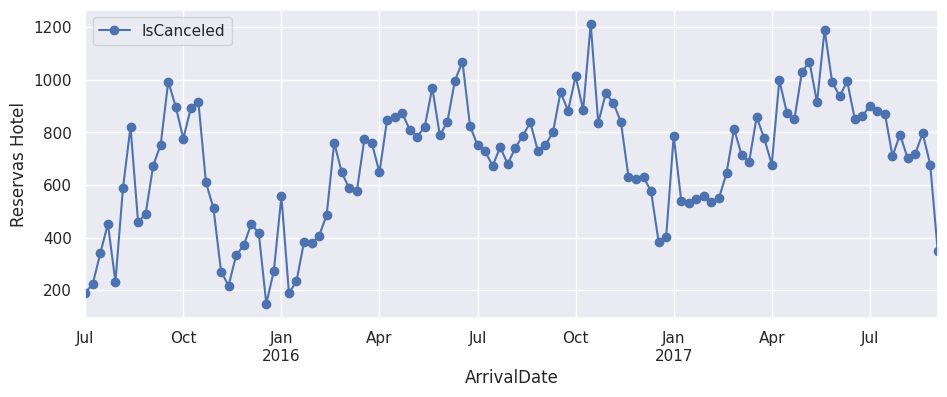

In [33]:
# Graficar Reservas
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
ax = df_w_r.plot(marker='o', linestyle='-')
ax.set_ylabel('Reservas Hotel');

Analisis Estacionalidad
 - Componente estacional, meses con mayores reservas en octubre y descenso de las reservas durante el mes de enero

## Modelo de Suavizado Exponencial

In [34]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

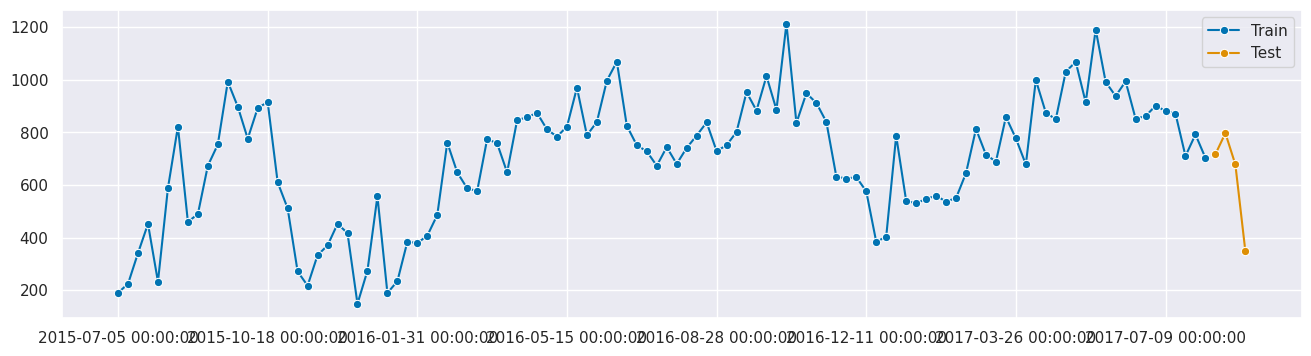

In [35]:
# Separamos la muestra entre train y test, vamos a predecir 4 periodos
y_train, y_test = temporal_train_test_split(y =df_w_r, test_size=4)
plot_series(y_train, y_test, labels=["Train", "Test"])

In [36]:
from sktime.forecasting.ets import AutoETS

In [37]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 5)

# step 3: specifying the forecasting algorithm (4) son los periodos que es trimestral
df_w_r_model = AutoETS(auto=True, sp=4, n_jobs=-1)

In [38]:
df_w_r_model.fit(y_train) # Se estima con los datos de train SO LO

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.

AutoETS(auto=True, n_jobs=-1, sp=4)

In [24]:
print(df_w_r_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  110
Model:                       ETS(ANA)   Log Likelihood                -695.621
Date:                Wed, 20 Dec 2023   AIC                           1407.243
Time:                        12:09:08   BIC                           1428.847
Sample:                    07-05-2015   HQIC                          1416.006
                         - 08-06-2017   Scale                        18211.088
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.6432      0.082      7.797      0.000       0.482       0.805
smoothing_seasonal  3.568e-05        nan        nan        nan         nan         nan
initial_level       

In [39]:
# Predicciones
model_predict_r = df_w_r_model.predict(fh)
print(model_predict_r)

            IsCanceled
2017-08-13  786.896063
2017-08-20  735.727456
2017-08-27  691.162663
2017-09-03  743.391248


In [40]:
model_predict_r_ints = df_w_r_model.predict_interval(fh, coverage=0.9) # Crear intervalo de prediccion
model_predict_r_ints

0             
                   0.9             
                 lower        upper
2017-08-13  564.925589  1008.866536
2017-08-20  471.805381   999.649531
2017-08-27  391.097950   991.227377
2017-09-03  411.091982  1075.690515

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

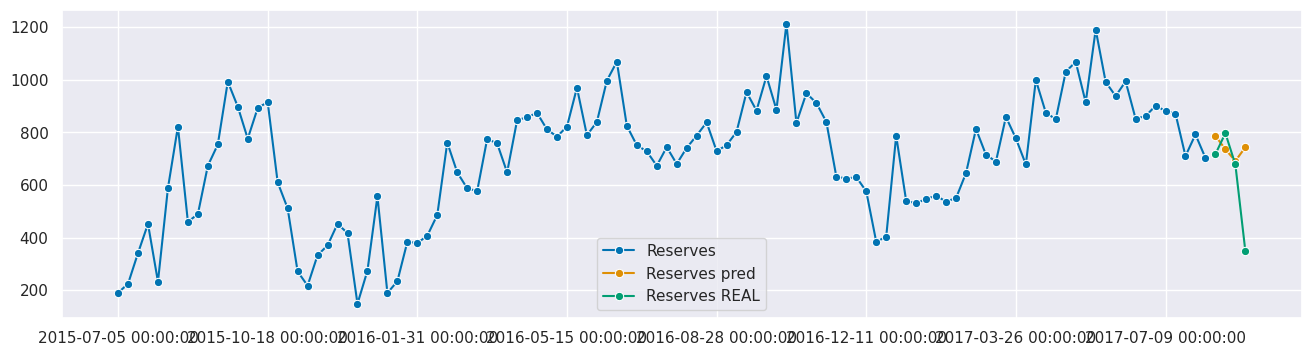

In [41]:
# Representar Predicciones
plot_series(y_train, model_predict_r,y_test, labels=["Reserves", "Reserves pred", "Reserves REAL"])

KeyError: ('IsCanceled', 0.9, 'lower')

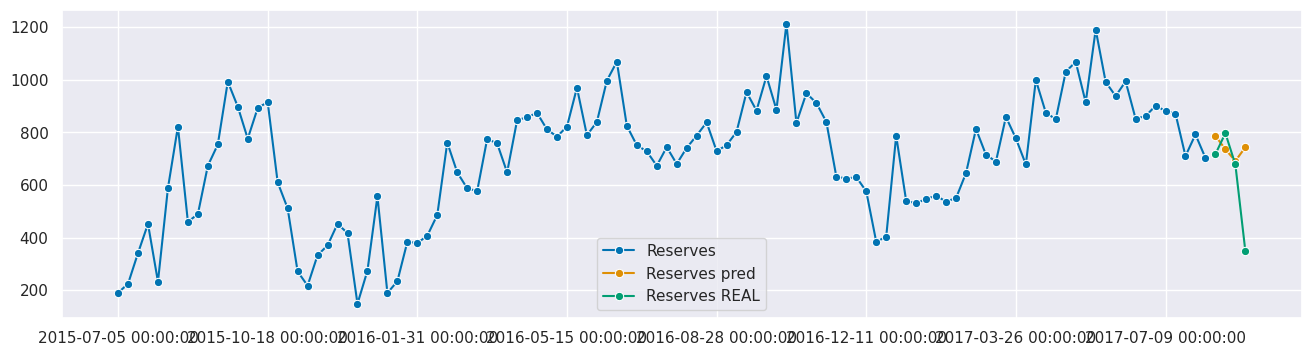

In [44]:
fig, ax = plot_series(y_train, model_predict_r, y_test, labels=["Reserves", "Reserves pred", "Reserves REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    model_predict_r_ints[('IsCanceled', 0.9, 'lower')],
    model_predict_r_ints[('IsCanceled', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')


Precision de las predicciones

- MAPE

In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, model_predict_r[0:4])  # Para calcular errores

In [ ]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, model_predict_r[0:4])

In [ ]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, model_predict_r[0:4]) # Unidades de medida, tiene mas sentido que la primera al no estar elevada al cuadrado

Estimamos modelo de forma manual

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend='additive', seasonal='multiplicative', sp=4)
forecaster.fit(y)

In [ ]:

y_pred = forecaster.predict(fh)
y_pred

In [ ]:
print(forecaster._fitted_forecaster.summary())

In [ ]:
forecaster.get_fitted_params()

In [ ]:
plot_series(y, y_pred, labels=["Reserves", "Reserves pred"])

Estimamos modelo de forma manual sin componente estacional

In [ ]:
forecaster = ExponentialSmoothing(trend='additive',seasonal=None, sp=4)
forecaster.fit(y)

In [ ]:
y_pred = forecaster.predict(fh)

In [ ]:
plot_series(y, y_pred, labels=["Reserves", "Reserves pred"])

Estimamos modelo de forma manual sin componente estacional y tendencia multiplicativa

In [ ]:
forecaster = ExponentialSmoothing(trend='mul',seasonal=None, sp=4)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["Reserves", "Reserves pred"])

Estimamos modelo de forma manual sin componente estacional y sin tendencia multiplicativa

In [ ]:
forecaster = ExponentialSmoothing(trend=None,seasonal=None, sp=4)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["Reserves", "Reserves pred"])

Estimamos modelo de forma manual sin componente estacional, multiplicative

In [ ]:
forecaster = ExponentialSmoothing(trend=None,seasonal="mul", sp=4)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["KO", "KO pred"])

Estimemos modelo de forma manual sin tendencia, additive

In [ ]:
forecaster = ExponentialSmoothing(trend=None,seasonal="add", sp=4)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["KO", "KO pred"])

Compara tendencia con tendencia additive, con y sin damped (Componente estacional aditivo)

In [ ]:
forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=False, sp=4)
forecaster.fit(y)
y_pred = forecaster.predict(fh)

forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=True, sp=4)
forecaster.fit(y)
y_pred_dump = forecaster.predict(fh)
plot_series(y["2009":], y_pred, y_pred_dump,labels=["KO", "KO pred","KO Pred Dumpeded"])